In [2]:
# Load train and test dataset
import pandas as pd

df = pd.read_csv('./basetable_oversample_7.csv', sep='\t')
print(df)
print(len(df[df['CD4/8'] == 'CD4']))
print(len(df[df['CD4/8'] == 'CD8']))

             v_gene     j_gene  cdr3_length  v_deletions  j_deletions  \
0         TRBV29-01  TRBJ02-05           30           23            5   
1         TRBV10-03  TRBJ02-05           39           11            5   
2         TRBV24-01  TRBJ01-02           42           12            0   
3         TRBV06-05  TRBJ02-02           36           11            8   
4         TRBV07-02  TRBJ02-03           45           11            4   
...             ...        ...          ...          ...          ...   
18513497  TRBV07-09  TRBJ01-05           42            5            4   
18513498  TRBV05-04  TRBJ02-03           42            4            5   
18513499  TRBV29-01  TRBJ01-01           33            8            1   
18513500  TRBV06-05  TRBJ02-07           39            0            2   
18513501  TRBV07-09  TRBJ02-05           48            7            4   

          n1_insertions  n2_insertions CD4/8  
0                     2              0   CD4  
1                     4      

In [3]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# Encoding trained parameters
x_1 = df.iloc[:, 0:7]
enc = OrdinalEncoder()
enc.fit(x_1[['v_gene', 'j_gene']])  # , 'j_gene'
x_1[['v_gene', 'j_gene']] = enc.transform(x_1[['v_gene', 'j_gene']])
X = x_1.values.astype(int)
print(X)

Y_1 = df.iloc[:, -1]
le = LabelEncoder()
le.fit(Y_1)
y = le.transform(Y_1)

features = df.columns[0:7].values

[[58 10 30 ...  5  2  0]
 [34 10 39 ...  5  4  7]
 [53  1 42 ...  0  0  6]
 ...
 [58  0 33 ...  1  2  2]
 [16 12 39 ...  2  0  2]
 [29 10 48 ...  4  5  8]]


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
from sklearn.feature_selection import SelectKBest, chi2

fs = SelectKBest(score_func=chi2, k='all') 
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)
print(X_test_fs)

[[28  8 42 ...  9  2  4]
 [29  1 39 ...  6  1  3]
 [22 10 39 ... 11 14  0]
 ...
 [28  7 48 ...  5  2  8]
 [54  7 42 ...  3  2  3]
 [49  6 45 ...  9 11  2]]


Feature v_gene:  80516.57784198904
Feature j_gene:  112557.49032976668
Feature cdr3_length:  497.2399336686973
Feature v_deletions:  15028.275228621413
Feature j_deletions:  7553.594843227213
Feature n1_insertions:  1433.0242815724846
Feature n2_insertions:  121.6236039955615


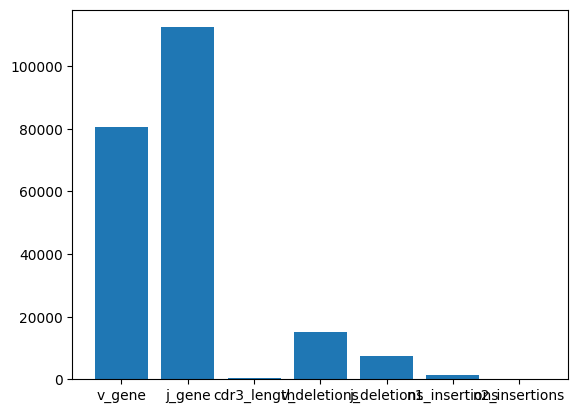

In [6]:
from matplotlib import pyplot as plt

# Select the most fitted features
for i, j in zip(features, range(len(fs.scores_))):
    print(f'Feature {i}:  {fs.scores_[j]}')
# plot the scores
plt.bar([i for i in features], fs.scores_)
plt.show()

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

model_pipeline = [LogisticRegression(solver='liblinear'), DecisionTreeClassifier(), KNeighborsClassifier(),
                  GaussianNB()]
model_list = ['Logistic Regression', 'Decision Tree', 'KNeighbors', 'GaussianNB']

# model evaluation
acc_list = []
auc_list = []
cm_list = []
fpr_list = []
tpr_list = []
y_known = []
pred = []
prob = []

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

for model in model_pipeline:
    model.fit(X_train_fs, y_train)
    y_pred = model.predict(X_test_fs)
    y_prob = model.predict_proba(X_test_fs)
    print(y_prob)

    acc_list.append(accuracy_score(y_test, y_pred))
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_prob[:, 1])
    fpr_list.append(false_positive_rate)
    tpr_list.append(true_positive_rate)
    auc_list.append(round(roc_auc_score(y_test, y_prob[:, 1]), 2))
    cm_list.append(confusion_matrix(y_test, y_pred))
    tp, tn, fn, fp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    cd4_num = tp + fn
    y_known.append(y_test)
    pred.append(y_pred)
    p_estimated = cd4_num / len(y_test)
    print(p_estimated)
    list_1 = y_prob[:, 0].tolist()
    prob.append(list_1)


[[0.48217514 0.51782486]
 [0.53118879 0.46881121]
 [0.50291334 0.49708666]
 ...
 [0.50896476 0.49103524]
 [0.50642471 0.49357529]
 [0.48731158 0.51268842]]
0.4988026308362463
[[0.         1.        ]
 [0.22222222 0.77777778]
 [0.5        0.5       ]
 ...
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]]
0.47155225334154716
[[0.2 0.8]
 [0.4 0.6]
 [0.6 0.4]
 ...
 [0.  1. ]
 [0.6 0.4]
 [0.6 0.4]]
0.44807911845974063
[[0.49974287 0.50025713]
 [0.53441507 0.46558493]
 [0.51273987 0.48726013]
 ...
 [0.50194368 0.49805632]
 [0.50593974 0.49406026]
 [0.5056356  0.4943644 ]]
0.5246372850521822


In [14]:
import seaborn as sns

# plot confusion matrix
fig = plt.figure(figsize=(18, 10))
for n in range(len(cm_list)):
    con_matrix = cm_list[n]
    model = model_list[n]
    sub = fig.add_subplot(2, 2, n + 1).set_title(model)
    cm_plot = sns.heatmap(con_matrix, annot=True, cmap='Blues', fmt='g')
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')
plt.show()

<Figure size 1800x1000 with 0 Axes>

IndexError: list index out of range

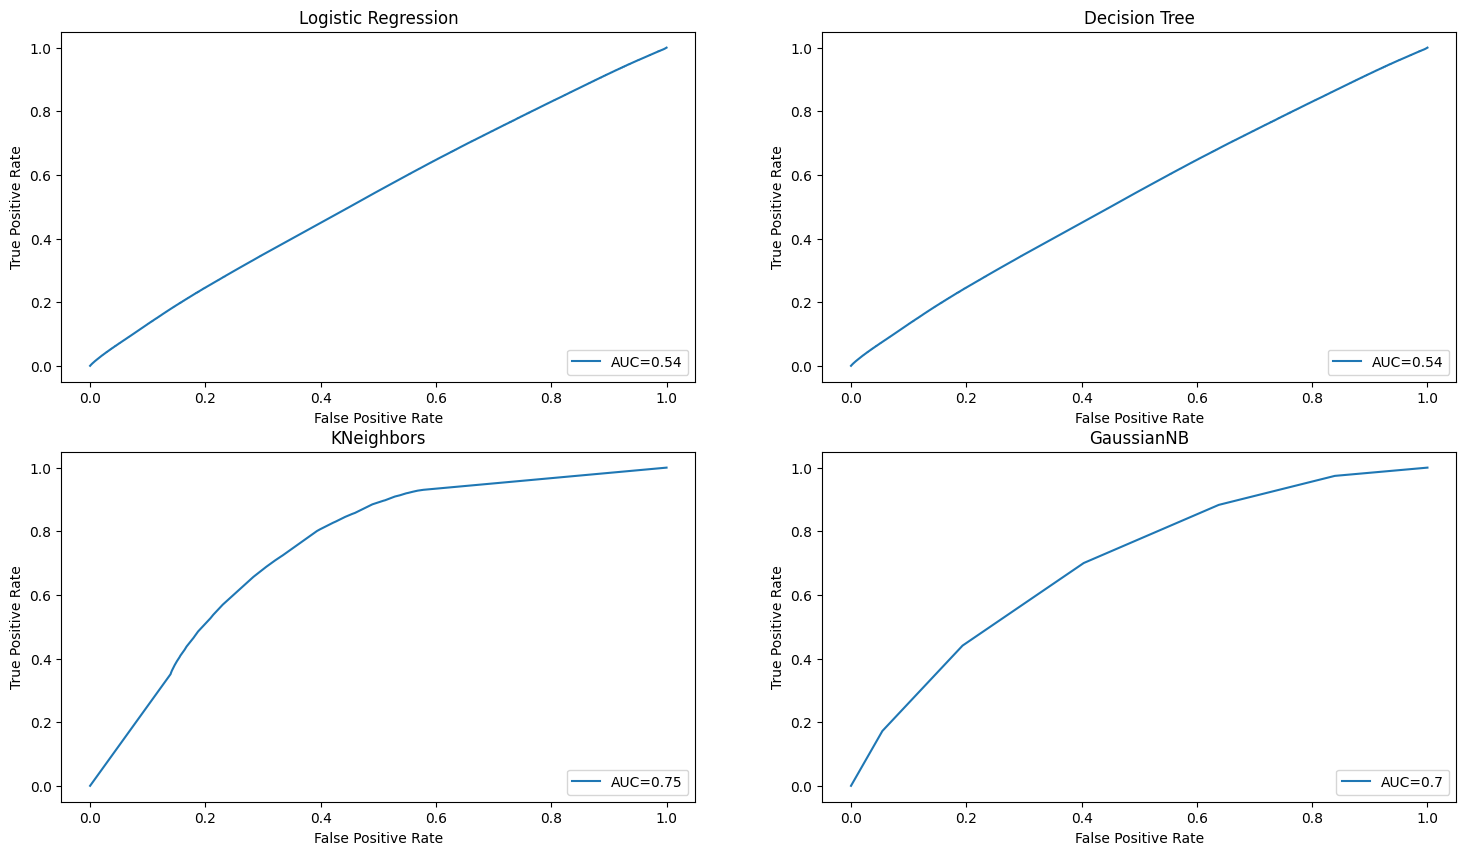

In [12]:
# plot ROC curves
fig = plt.figure(figsize=(18, 10))
for n in range(len(acc_list)):
    auc_value = auc_list[n]
    fpr = fpr_list[n]
    tpr = tpr_list[n]
    model = model_list[n]
    sub = fig.add_subplot(2, 2, n + 1).set_title(model)
    plt.plot(fpr, tpr, label="AUC=" + str(auc_value))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
plt.show()

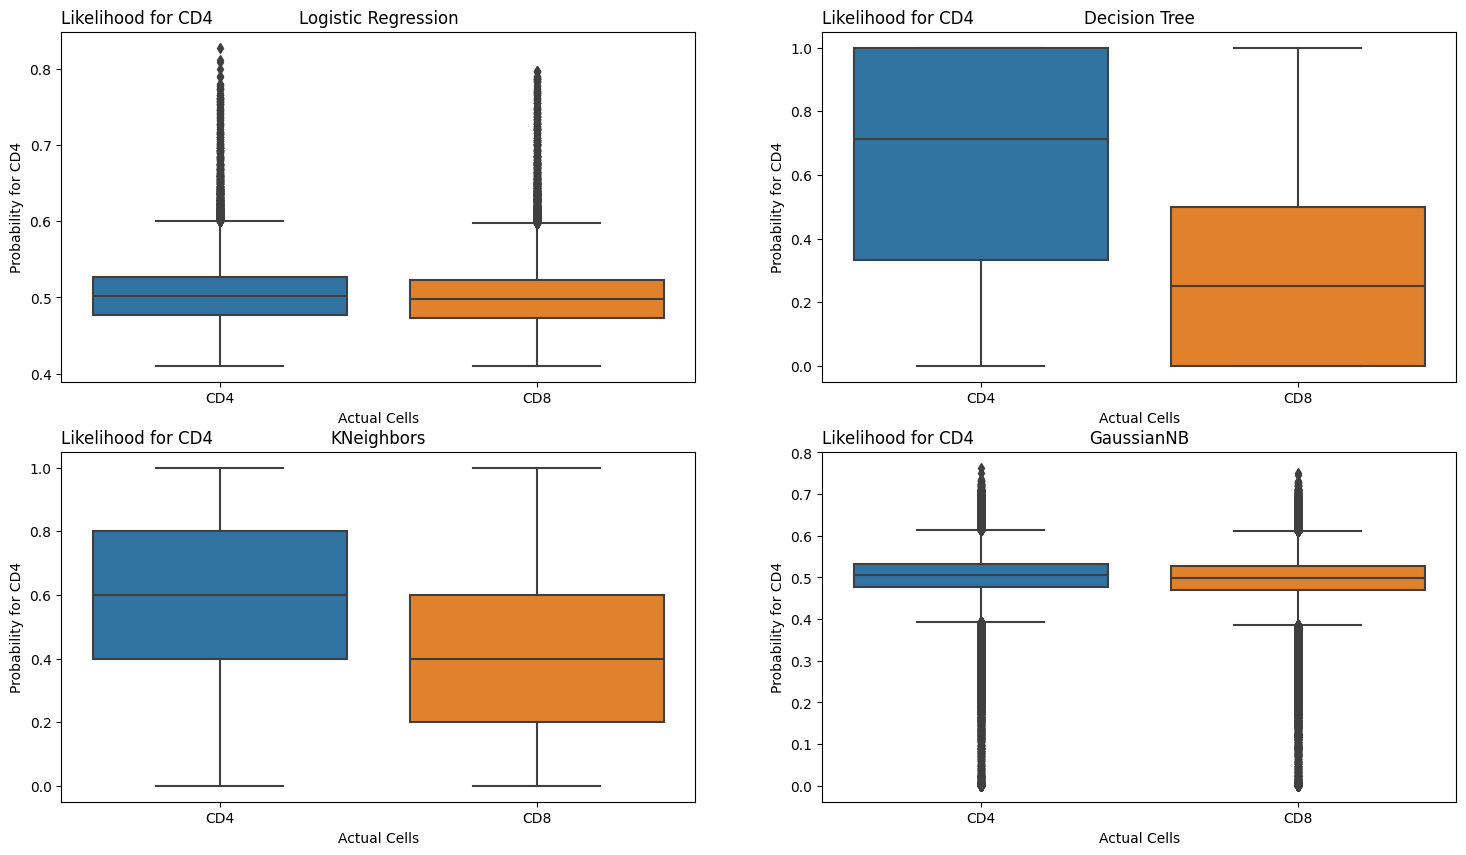

In [22]:
# box plot
fig = plt.figure(figsize=(18, 10))
for n in range(len(y_known)):
    # add stripplot
    # ax = sns.stripplot(x='cells', y='probability', data=df, color="orange", jitter=0.2, size=2.5)
    model = model_list[n]
    sub = fig.add_subplot(2, 2, n + 1).set_title(model)
    ax = sns.boxplot(x=y_known[n], y=prob[n])
    ax.set_xticklabels(labels=['CD4', 'CD8'])
    # add label & title
    plt.ylabel('Probability for CD4')
    plt.xlabel('Actual Cells')
    plt.title("Likelihood for CD4", loc="left")
plt.show()

In [23]:
# Accuracy and AUC
result_df = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list})
print(result_df)

                 Model  Accuracy   AUC
0  Logistic Regression  0.524744  0.54
1        Decision Tree  0.695016  0.75
2           KNeighbors  0.648239  0.70
3           GaussianNB  0.528642  0.54
